# GCN Karate club 

## Load library 

In [1]:
import numpy as np 
import networkx as nx 
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

## Load and visualize datasetss

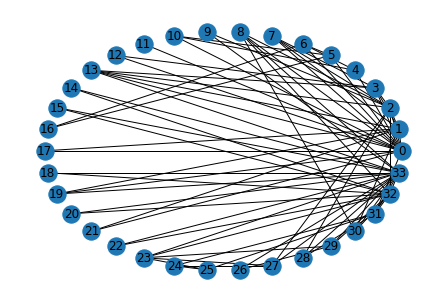

In [2]:
G = nx.karate_club_graph()
# Circular visualisation
nx.draw_circular(G, with_labels=True)
plt.show()

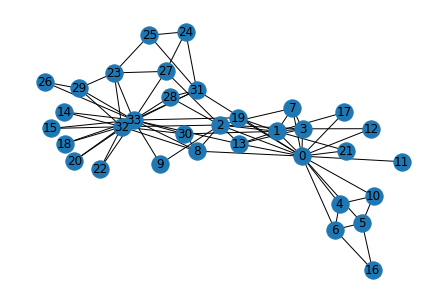

In [3]:
# Same graph
nx.draw(G, with_labels=True)
plt.show()

## Classic Algorithm and Communities detection

In [4]:
from networkx.algorithms.community import greedy_modularity_communities
communities = greedy_modularity_communities(G)

In [5]:
colors = np.zeros(G.number_of_nodes()) # Initialize a colors assignement with the number of nodes
for i,c in enumerate(communities):
    colors[list(c)] = i # Assign the same color to each nodes in a community 
    

n_classes = np.unique(colors).shape[0] # Number of community 
    

In [6]:
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.circular_layout(nx_G) 

    nx.draw(
        nx_G, pos, with_labels=label_map is not None, 
        labels=label_map, 
        node_color=node_color, 
        ax=ax, **kwargs)



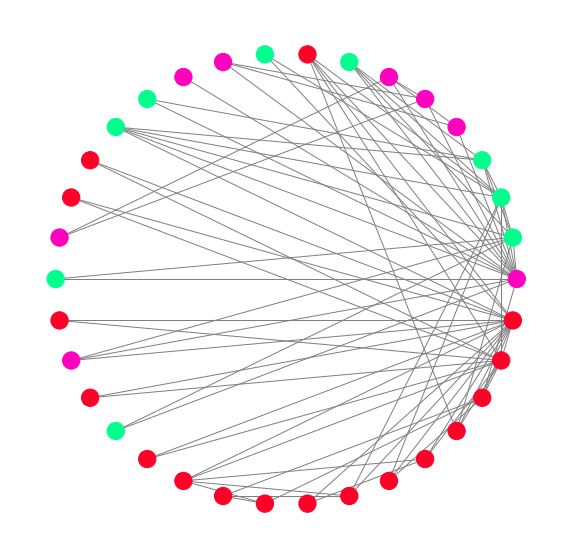

In [7]:
_ = draw_kkl(G, None, colors, cmap='gist_rainbow', edge_color='gray')

## True communitie in Karate club

In [8]:
club_labels = nx.get_node_attributes(G,'club') # Get the true communities

In [9]:
class_dict = {'Mr. Hi':0,'Officer':1} # The two classes in Zakary community
true_labels = []
for v in club_labels.values():
    true_labels.append(class_dict[v])
    
n_true_classes = 2


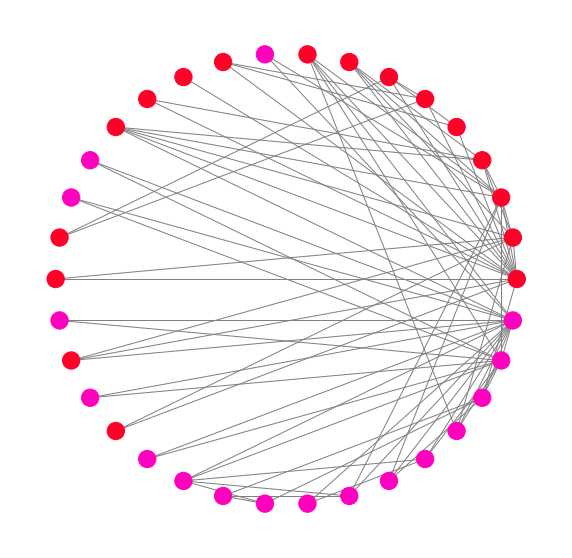

In [10]:
_ = draw_kkl(G, None, true_labels, cmap='gist_rainbow', edge_color='gray')

## GCN Model 
[GCN Paper here](https://arxiv.org/abs/1609.02907) 



We must first add self-connection to our adjacency matrix $A$ 

$\tilde{A} = A + I$

then, we calculate the normalize Adjacency Matrix $\hat{A}$

$ \hat{A}=\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} $ 

In [11]:
# Get the adjacency matrix 

A = nx.linalg.adjacency_matrix(G)

# Get the adjacency matrix (numpy)

A = nx.to_numpy_array(G)

In [12]:
# Add self connection 

A_t = A + np.eye(G.number_of_nodes())

In [13]:
# Compute degree matrix of A_t 
d  = np.sum(A_t,axis=0) # Degree in 1-D NP array
D_t = np.diag(d)

# Compute the square root inverse on D_t and A_t 
D_t_inv = np.linalg.inv(sqrtm(D_t))


In [14]:
# Finally compute A_hat 

A_hat = D_t_inv @ A_t @ D_t_inv

Now we want to train our GCN in a supervised way to classify the nodes in the right community. 
The learning is said to be semi-supervised since we use the structure of the whole graph but only a few labels to train the model. 
The forward phase is the generation of embeddings by message passing, as in the following equation: 

$ Z=f(X, A)=\operatorname{softmax}\left(\hat{A} \operatorname{ReLU}\left(\hat{A} X W^{(0)}\right) W^{(1)}\right) $ 

The softmax function changes our output into a probability distribution for each class that sums to 1. 

In [15]:
# Load torch library 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Two_Layer_GCN(nn.Module):
    def __init__(self,dim_in,dim_h,dim_out):
        # A_hat --> normalize adjacency matrix
        # X --> Matrix of features
        # dim_in --> Input dimension of X, A_hat 
        # dim_h --> Hidden dimension
        # dim_out --> Output dimension, number of classes 
        
        super(Two_Layer_GCN,self).__init__()
            
        # Layers
        self.W0 = nn.Parameter(torch.rand((dim_in,dim_h),requires_grad=True)) # Tell pytorch its a trainable parameter
        self.W1 = nn.Parameter(torch.rand((dim_h,dim_out),requires_grad=True)) 
        self.relu = nn.ReLU()
        #self.myparameters = nn.ParameterList(self.W0, self.W1)
        
    def embbed(self,A_hat,X):
        # Get the embeddings of the nodes (before softmax)
        A_hat = torch.Tensor(A_hat) # Dim N*N (N Number of nodes)
        X = torch.Tensor(X)  # N* dim_in 
        hidden = self.relu(A_hat @ X @ self.W0) # Dim N*H
        out = A_hat @ hidden @ self.W1 # Dim N*2
        return out
        
        
    def forward(self,A_hat,X):
        # Perform a forward pass
        A_hat = torch.Tensor(A_hat) # Dim N*N (N Number of nodes)
        X = torch.Tensor(X)  # N* dim_in 
        hidden = A_hat @ X @ self.W0 # Dim N*H
        hidden = self.relu(hidden)
        out = A_hat @ hidden @ self.W1# Dim N*2
        #out = self.relu(out)
        
        return out


In [16]:
gcn = Two_Layer_GCN(G.number_of_nodes(),dim_h=10,dim_out= n_true_classes)

In [17]:
# Test
output = gcn.forward(A_hat=A_hat,X=A)
print(output.size()) # Must be N*2 


torch.Size([34, 2])


### Training 
Now we'll train our two layer GCN in a supervise way 

In [18]:
# Training parameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1

optimizer= torch.optim.SGD(gcn.parameters(),lr=learning_rate)
epoch = 1000

We must split our graph nodes into train and test

In [19]:
train_nodes = torch.LongTensor([0, 1, 9,4,7,3,2])
test_nodes = torch.LongTensor([i for i in range(G.number_of_nodes()) if i not in train_nodes])
true_labels = torch.LongTensor(true_labels)

In [20]:
true_labels_2= np.zeros((G.number_of_nodes(),2))
for i,a in enumerate(true_labels_2):
    a[true_labels[i]] = 1
    
true_labels_2 = torch.Tensor(true_labels_2)

In [21]:
criterion
m = nn.Sigmoid()
criterion = nn.BCELoss()


In [22]:
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
for ep in range(epoch):
    
    output = gcn.forward(A_hat=A_hat,X=A)
    
    pred = torch.argmax(output,dim=1)
    #print(output.dtype,true_labels_2.dtype)
    output = m(output)
    loss = criterion(output[train_nodes], true_labels_2[train_nodes])
    
        
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    acc_train = (true_labels[train_nodes] == pred[train_nodes]).sum()/len(train_nodes)
    accuracy_train.append(acc_train)
    loss_train.append(loss.item())
    with torch.no_grad():
        loss = criterion(output[test_nodes], true_labels_2[test_nodes])
        acc_test = (true_labels[test_nodes] == pred[test_nodes]).sum()/len(test_nodes)
        loss_test.append(loss.item())
        accuracy_test.append(acc_test)
    
    if ep%100==0:
        print('EPOCH:',ep,'Accuracy test:',acc_test,'Loss Test:',loss_test[ep],'Loss train',loss_train[ep])
    
    

Gradient of W0 w.r.t Loss tensor(0.0194)
Gradient of W1 w.r.t Loss tensor(0.3673)
EPOCH: 0 Accuracy test: tensor(0.4074) Loss Test: 12.26799488067627 Loss train 24.762807846069336
Gradient of W0 w.r.t Loss tensor(9.4732e-06)
Gradient of W1 w.r.t Loss tensor(0.0002)
EPOCH: 100 Accuracy test: tensor(0.4074) Loss Test: 0.8906897306442261 Loss train 0.24494533240795135
Gradient of W0 w.r.t Loss tensor(8.1423e-06)
Gradient of W1 w.r.t Loss tensor(0.0002)
EPOCH: 200 Accuracy test: tensor(0.7037) Loss Test: 0.49970144033432007 Loss train 0.17401961982250214
Gradient of W0 w.r.t Loss tensor(3.8523e-06)
Gradient of W1 w.r.t Loss tensor(0.0002)
EPOCH: 300 Accuracy test: tensor(0.9630) Loss Test: 0.24597308039665222 Loss train 0.11436028778553009
Gradient of W0 w.r.t Loss tensor(1.5594e-06)
Gradient of W1 w.r.t Loss tensor(0.0001)
EPOCH: 400 Accuracy test: tensor(0.9630) Loss Test: 0.14547505974769592 Loss train 0.07744317501783371
Gradient of W0 w.r.t Loss tensor(5.2721e-07)
Gradient of W1 w.r.t

In [23]:
print(ep)

999


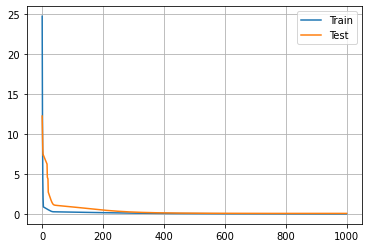

In [24]:
fig, ax = plt.subplots()
ax.plot(loss_train, label='Train')
ax.plot(loss_test, label='Test')
ax.legend()
ax.grid()

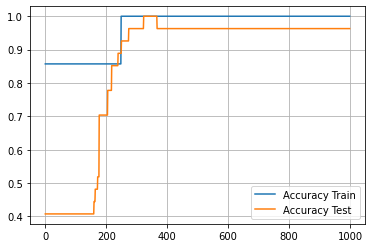

In [25]:
fig, ax = plt.subplots()
ax.plot(accuracy_train, label='Accuracy Train')
ax.plot(accuracy_test, label='Accuracy Test')
ax.legend()
ax.grid()

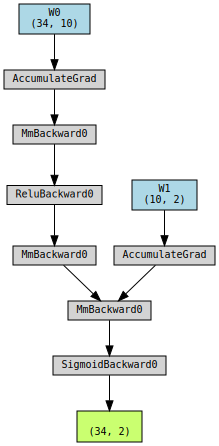

In [27]:
# Visualize the computation graph
from torchviz import make_dot

make_dot(output, params=dict(gcn.named_parameters()))

In [28]:
output = gcn.forward(A_hat=A_hat,X=A) 
pred = torch.argmax(output,dim=1)

### GCN Prediction

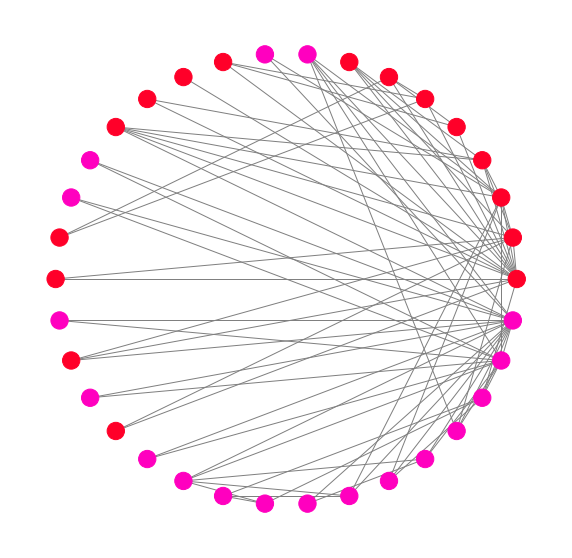

In [30]:
_ = draw_kkl(G, None, pred, cmap='gist_rainbow', edge_color='gray')

### Ground Truth

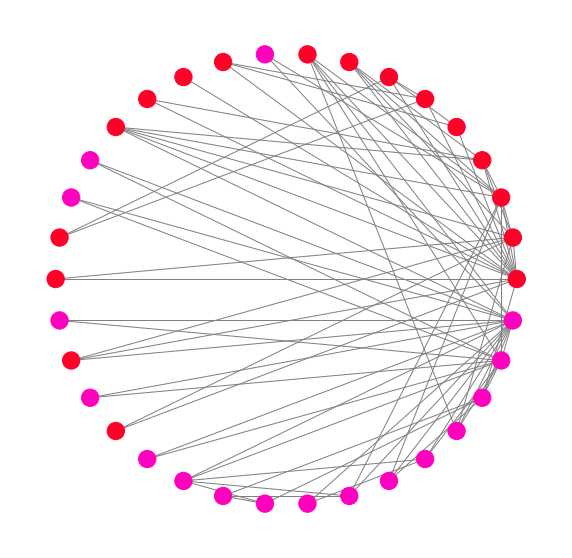

In [31]:
_ = draw_kkl(G, None, true_labels, cmap='gist_rainbow', edge_color='gray')